In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
data = pd.read_csv('adult.csv')

In [121]:
# preparing the data

def get_categories(array):                      # takes array of featuers in our current subset
    no_of_categories = []
    for feature in array:
        no_of_categories.append(data[feature].nunique())
    return no_of_categories

def encode_data(array):
    array.append('income')
    data_subset = data[array]
    data_subset  = pd.get_dummies(data_subset, columns = array , drop_first=False)
    data_subset.head()
    return data_subset                                  # now we got only the subset of featuers we want and we encoded them

def split_data(data):
    train_data, tmp_data = train_test_split(data, test_size=0.3, random_state=42)                    # train_data          #22792 rows
    val_data, test_data = train_test_split(tmp_data, test_size=0.5, random_state=42)                # val_data            #4884 rows

        # we will assume income_<=50K --> yes , income_>50K --> no       
    train_data_yes = train_data[train_data['income_<=50K'] == True] # 17291 rows 
    train_data_no = train_data[train_data['income_>50K'] == True]   # 5501 rows
    train_data_labels = train_data['income_<=50K'].values 
    train_data.drop(columns=['income_<=50K','income_>50K'],inplace=True)

    train_data_yes = train_data_yes.copy()
    train_data_no = train_data_no.copy()
    train_data_yes.drop(columns=['income_<=50K','income_>50K'], inplace=True)
    train_data_no.drop(columns=['income_<=50K','income_>50K'], inplace=True)



    val_data = val_data.copy()
    test_data = test_data.copy()

    # getting label col. for validation and testing data
    val_data_labels = val_data['income_<=50K'].values
    test_data_labels = test_data['income_<=50K'].values

    # dropping target col.
    val_data.drop(columns=['income_<=50K','income_>50K'], inplace=True)
    test_data.drop(columns=['income_<=50K','income_>50K'], inplace=True)

    return train_data, train_data_yes, train_data_no, train_data_labels, val_data, val_data_labels , test_data, test_data_labels


In [123]:
# calculating the prior probabilities of each class
yes_samples = 17291
no_samples = 5501
total_samples = 22792
def calculate_prior_prob_yes(alpha):
    prob_yes = (yes_samples+alpha) / (total_samples+(alpha*2)) 
    return prob_yes
def calculate_prior_prob_no(alpha):     # 2 for number of classes
    prob_no = (no_samples+alpha) / (total_samples+(alpha*2))  
    return prob_no

In [ ]:
# calculating the likelihood


# calculating prob(features/yes)
def calculate_likelihood_yes(no_of_categories, values_yes, alpha):
    values_yes = values_yes.to_numpy()
    prob_given_yes = []
    category_index = 0
    category_counter = no_of_categories[category_index] - 1
    for col_idx, col in enumerate(values_yes.T):
        count = col.sum()
        prob_given_yes.append((count+alpha)/(yes_samples+(alpha*no_of_categories[category_index])))
        if col_idx ==  category_counter:
            category_index+=1
            if category_index < len(no_of_categories) - 1:
                category_counter += no_of_categories[category_index] - 1
    return prob_given_yes



# calculating prob(features/no)
def calculate_likelihood_no(no_of_categories, values_no, alpha):
    prob_given_no = []
    category_index = 0
    category_counter = no_of_categories[category_index] - 1
    values_no = values_no.to_numpy()
    for col_idx, col in enumerate(values_no.T):
        count = col.sum()
        prob_given_no.append((count+alpha)/(no_samples+(alpha*no_of_categories[category_index])))
        if col_idx == category_counter:
            category_index+=1
            if category_index < len(no_of_categories) - 1:
                category_counter += no_of_categories[category_index] - 1 
    return prob_given_no
    




In [ ]:
# calculating prediction

alpha_values = [0.001,0.1, 0.5, 1.0, 2.0, 5.0]
correct_predictions = []

def calculate_predictions(val_data,val_data_labels, no_of_categories, values_yes, values_no):       # must take validation data & its labels, train_data_yes, train_data_no , categories
    col_names = values_yes.columns.to_numpy()
    val_data_arr = val_data.to_numpy()  #4884 rows
    prediction_yes_for_alphas = []         # supposed to be 4884*5
    prediction_no_for_alphas = []
    # calculate the prob. that its a yes class

    for alpha in alpha_values:
        likelihood_yes = calculate_likelihood_yes(no_of_categories, values_yes ,alpha)
        prediction_yes = []
        log_yes = np.log(calculate_prior_prob_yes(alpha))
        for i in range(0,len(val_data_arr)):
            prob = log_yes
            for j in range(0,len(likelihood_yes)):
                if val_data_arr[i][j] == True:
                    prob+= np.log(likelihood_yes[j])
            prediction_yes.append(prob)
        prediction_yes_for_alphas.append(prediction_yes)


    # calculate the prob. that its a no class
    for alpha in alpha_values:
        likelihood_no = calculate_likelihood_no(no_of_categories, values_no, alpha)
        prediction_no = []
        log_no = np.log(calculate_prior_prob_no(alpha))
        for i in range(0,len(val_data_arr)):
            prob = log_no
            for j in range(0,len(likelihood_no)):
                if val_data_arr[i][j] == True:
                    prob+= np.log(likelihood_no[j])
            prediction_no.append(prob)
        prediction_no_for_alphas.append(prediction_no)

    # deciding which class has higher prob.
    final_predictions_for_all_alphas = []
    for yes_array, no_array in zip(prediction_yes_for_alphas , prediction_no_for_alphas):
        income_low = []	    # yes       <=50 --> if false then sample is income high
        for i in range(0,len(val_data_arr)):
            if yes_array[i] > no_array[i]:
                income_low.append(True)
            else:
                income_low.append(False)
        final_predictions_for_all_alphas.append(income_low)                 # each array corresponds to final predictions
                                                                            #  for val data using diff. alpha

    index = 0
    best_alpha = 0
    correct_predictions.clear()
    for income in final_predictions_for_all_alphas:
        no_of_correct_predictions = 0
        for i in range(0,len(income)):
            if income[i] == val_data_labels[i]:
                no_of_correct_predictions+=1
        correct_predictions.append(no_of_correct_predictions)
        # print(f"number of correct predictions for alpha = {alpha_values[index]} --> {no_of_correct_predictions}")
        # print(f"miss classification rate = {1-(no_of_correct_predictions/len(val_data_labels))}")
        index+=1
    best_alpha = np.argmax(correct_predictions)  
    print(f"best alpha is {alpha_values[best_alpha]} with accuracy = {(correct_predictions[best_alpha]/4884)*100}%")

    return likelihood_yes,likelihood_no, col_names







        



In [126]:
def plot_feature_likelihoods(likelihood_yes, likelihood_no, column_names):
    x = np.arange(len(column_names))

    plt.figure(figsize=(14, 6))

    plt.plot(x, likelihood_yes, marker='o', label='P(feature | YES)', linewidth=1)
    plt.plot(x, likelihood_no, marker='s', label='P(feature | NO)', linewidth=1)

    plt.xticks(x, column_names, rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Probability")
    plt.title("Feature Likelihoods: P(feature | YES) vs P(feature | NO)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

--------------------------------------------------------------------
best alpha is 5.0 with accuracy = 76.84275184275184%


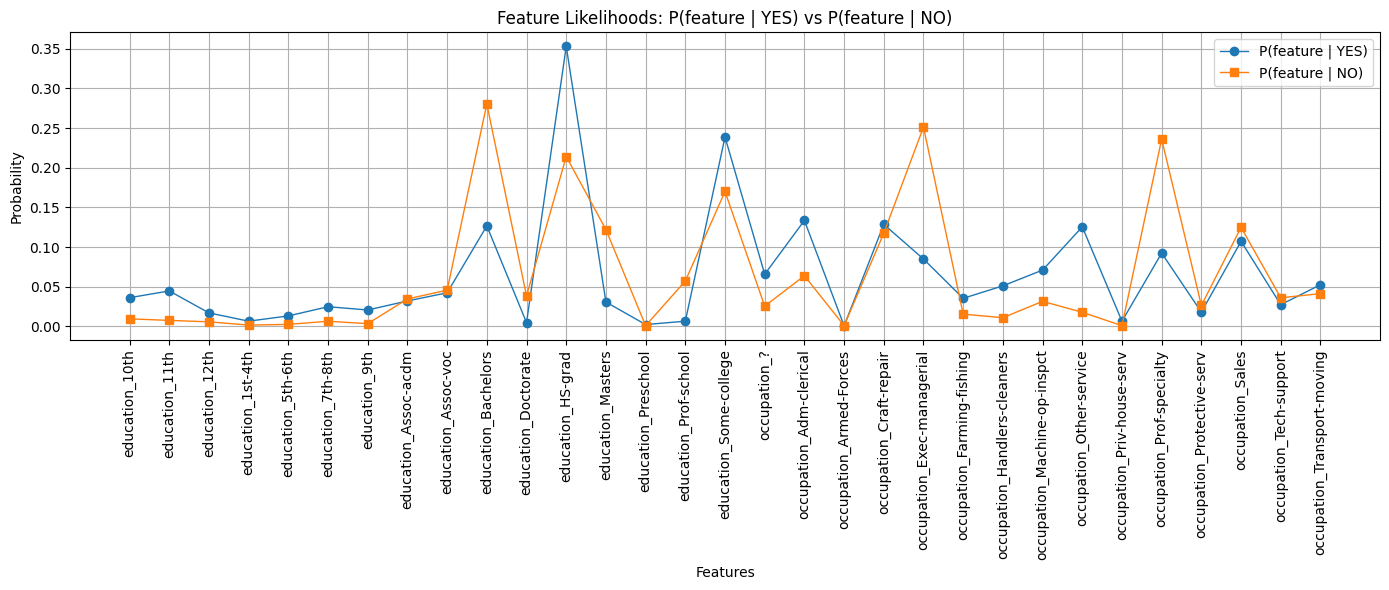

--------------------------------------------------------------------
best alpha is 0.001 with accuracy = 74.91809991809993%


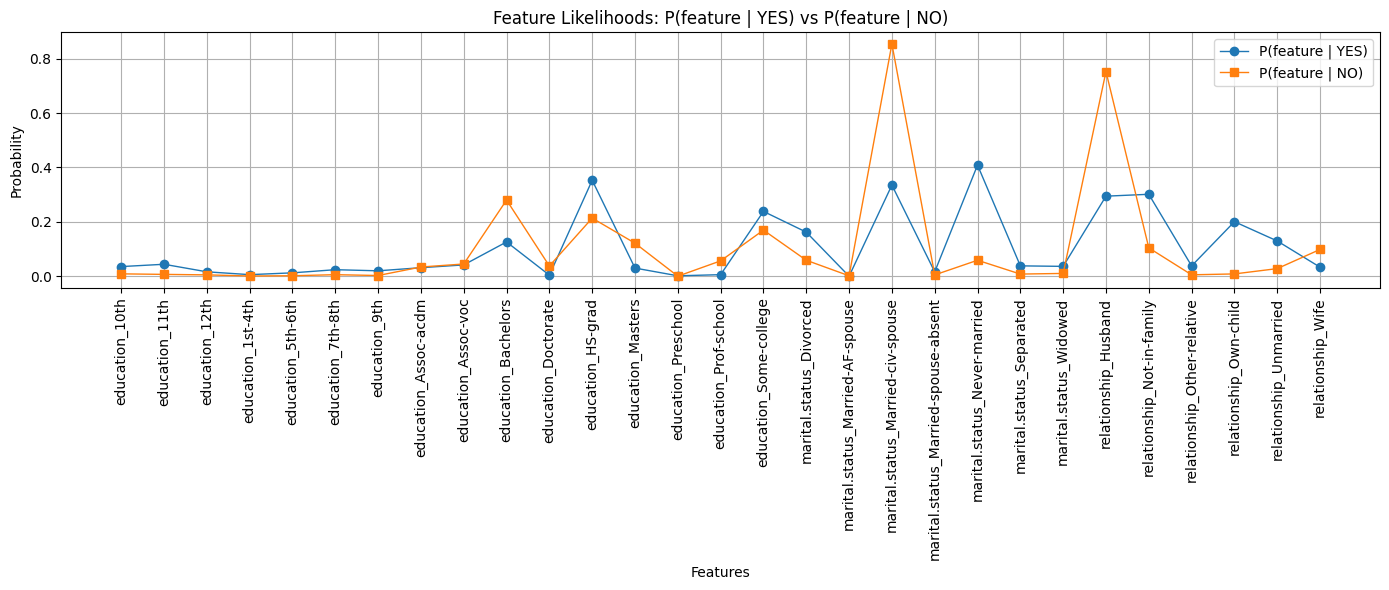

--------------------------------------------------------------------
best alpha is 5.0 with accuracy = 81.04013104013103%


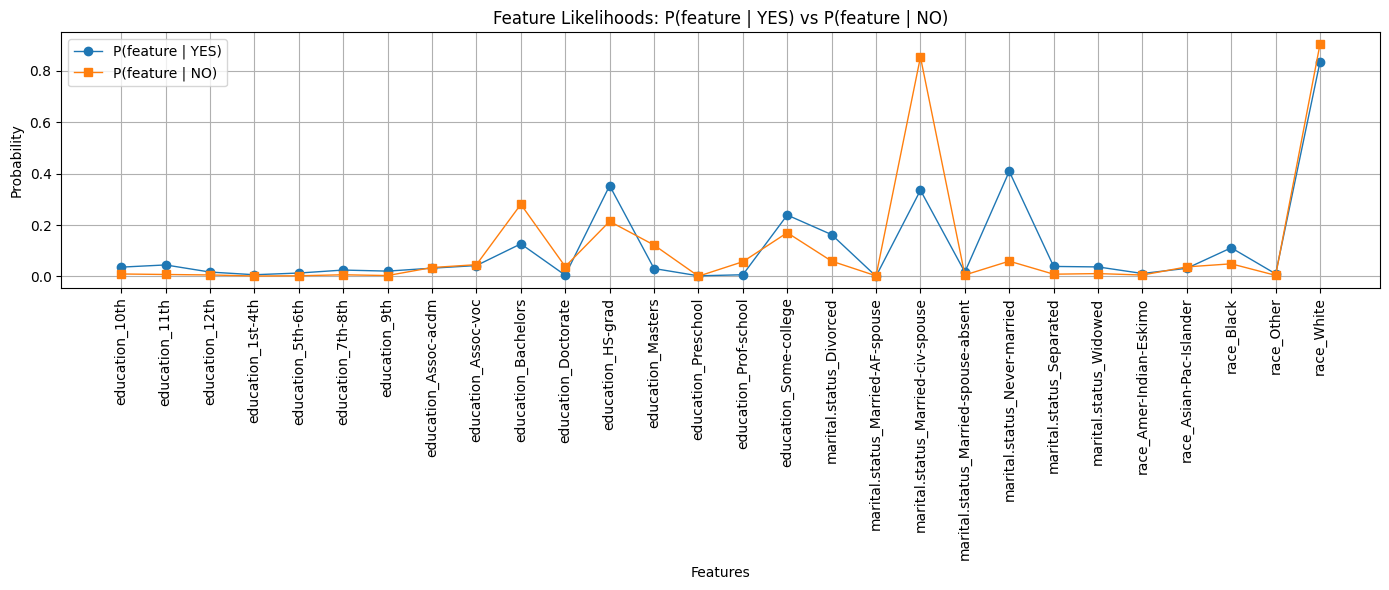

--------------------------------------------------------------------
best alpha is 0.5 with accuracy = 81.63390663390663%


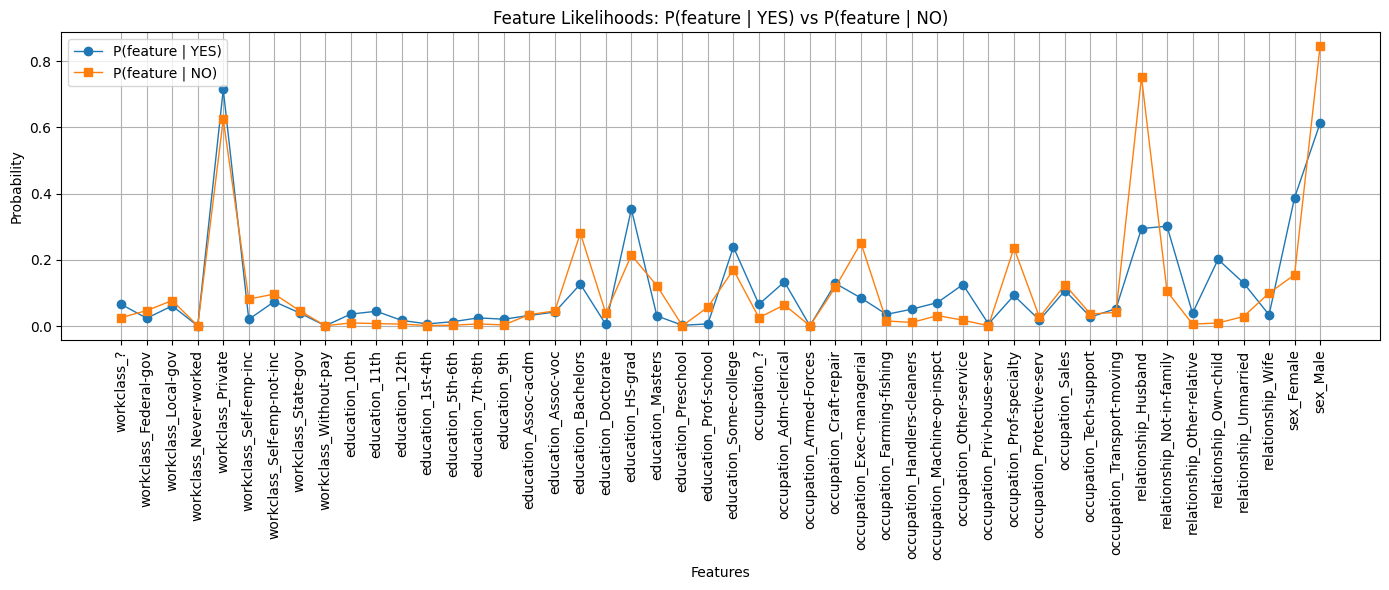

--------------------------------------------------------------------
best alpha is 0.001 with accuracy = 80.5896805896806%


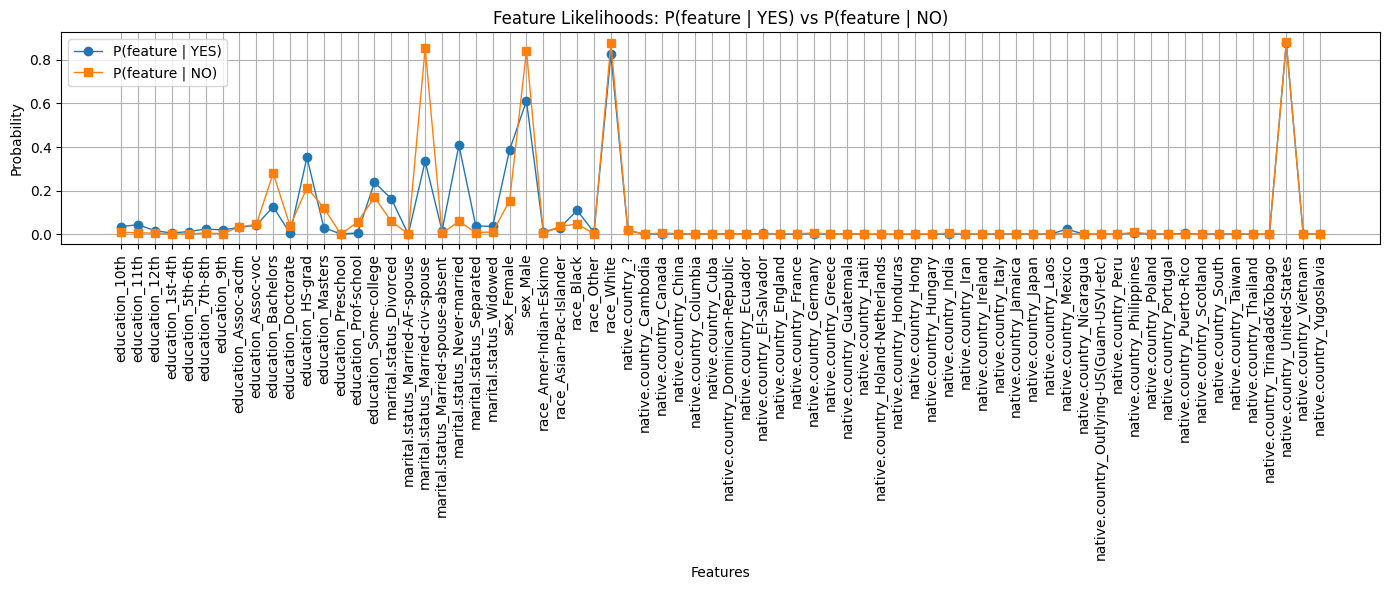

--------------------------------------------------------------------
best alpha is 5.0 with accuracy = 79.03357903357903%


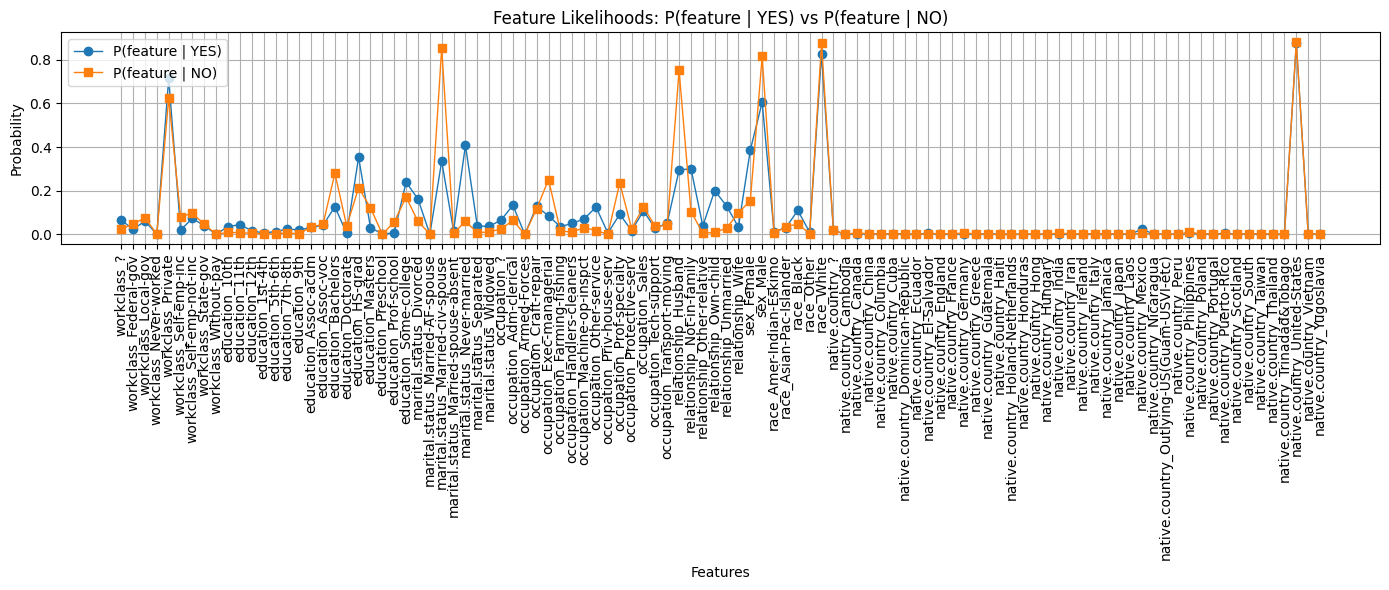

In [127]:
subsets = [
    ["education", "occupation"],
    ["education", "marital.status", "relationship"],
    ["education", "marital.status", "race"],
    ["workclass", "education", "occupation", "relationship", "sex"],
    ["education", "marital.status", "sex", "race", "native.country"],
    ['workclass', 'education', 'marital.status','occupation','relationship','sex','race','native.country']
]
probs_given_yes = []
probs_given_no = []
for subset in subsets:
    categories = get_categories(subset)
    train_data, train_data_yes, train_data_no, train_data_labels, val_data, val_data_labels , test_data, test_data_labels = split_data(encode_data(subset))
    print('--------------------------------------------------------------------')
    yes, no, col_names = calculate_predictions(val_data, val_data_labels, categories, train_data_yes, train_data_no)
    plot_feature_likelihoods(yes, no, col_names)



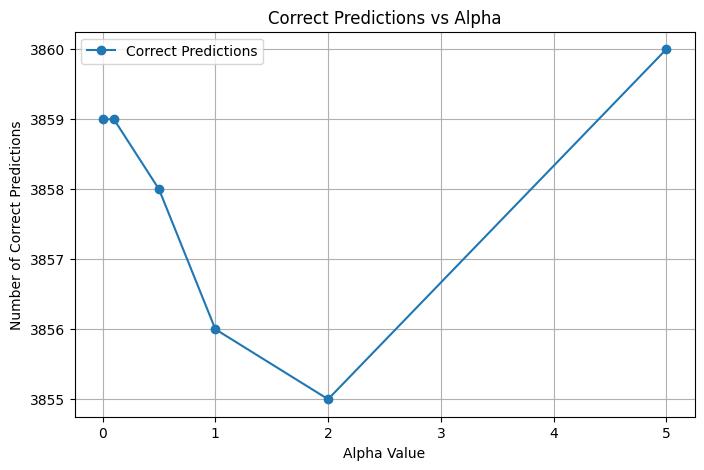

In [128]:
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, correct_predictions, marker='o', label='Correct Predictions')
plt.xlabel('Alpha Value')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

### **Independence Assumption in the Adult Dataset**

The Adult dataset contains several correlated categorical features  
(e.g., **education–occupation**, **marital-status–relationship**).  
These correlations violate the **conditional independence assumption** of Naive Bayes.

As a result:

- The model may become **overconfident** in its predictions  
  because correlated features effectively **“double-count”** evidence.
- Predicted probabilities become **less reliable** and poorly calibrated.

However:

- Naive Bayes often still achieves **good classification accuracy**,  
  because it only needs **relative likelihoods** to choose the correct class—not perfect independence.

In summary, accuracy may remain strong,  
but **probability estimates should be interpreted with caution**.


In [129]:
# using sklearn's library
model = MultinomialNB(alpha=5)
model.fit(train_data,train_data_labels)
y_pred = model.predict(test_data)
accuracy = accuracy_score(test_data_labels, y_pred)
print(f"Accuracy: {accuracy*100}%")
print("both the sklearn's library and our manual model has very close, almost same accuracy")



Accuracy: 79.69293756397134%
both the sklearn's library and our manual model has very close, almost same accuracy
